In [27]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmcrameri import cm as cmc

import seaborn as sns

sns.set_theme("notebook")

In [28]:
def calc_eke(config, xstart=20, xstop=70, tstart=8*60):
    ds = xr.open_dataset(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/output/{config}.nc").squeeze()
    ds = ds.isel(xC=slice(xstart,xstop),xF=slice(xstart,xstop+1), time=slice(tstart,None))
    
    u = ds.u 
    v = ds.v

    umean = u.mean(["yC", "xF"])
    vmean = v.mean(["yF", "xC"])

    unod = u - umean 
    vnod = v - vmean 

    unod2 = unod**2 
    vnod2 = vnod**2 

    EKE = 0.5*(unod2.mean(["yC", "xF"])+vnod2.mean(["yF", "xC"]))
    
    return EKE


def calc_enstrophy(config, xstart=20, xstop=70, tstart=8*60):
    ds = xr.open_dataset(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/output/{config}.nc").squeeze()
    ds = ds.isel(xC=slice(xstart,xstop),xF=slice(xstart,xstop+1), time=slice(tstart,None))
    
    enstrophy = 0.5*(ds.omega**2).mean(["xF", "yF"])
    
    return enstrophy


def calc_vorticity_contribution(config, depth=500, tstart=8*60):
    ds = xr.open_dataset(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/output/extracted_circ/{config}_circ.nc").squeeze()
    ds = ds.isel(time=slice(tstart,None))
    ds = ds.sel(depth=depth)
    
    return ds.circulation-ds.linear_estimate

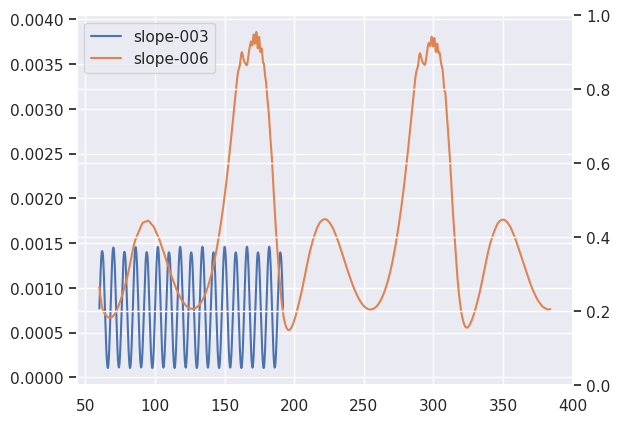

In [29]:
fig, ax = plt.subplots()

axt = ax.twinx()

configs = ["slope-003", "slope-006"]
for config in configs:
    EKE = calc_eke(config)
    t_days = EKE.time / np.timedelta64(1, 'D')
    ax.plot(t_days, EKE, label=config)
    
ax.legend()

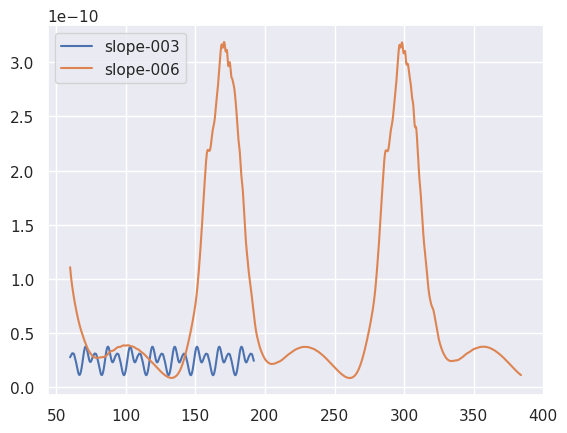

In [30]:
fig, ax = plt.subplots()

configs = ["slope-003", "slope-006"]
for config in configs:
    enstrophy = calc_enstrophy(config)
    t_days = enstrophy.time / np.timedelta64(1, 'D')
    
    ax.plot(t_days, enstrophy, label=config)
    
ax.legend()

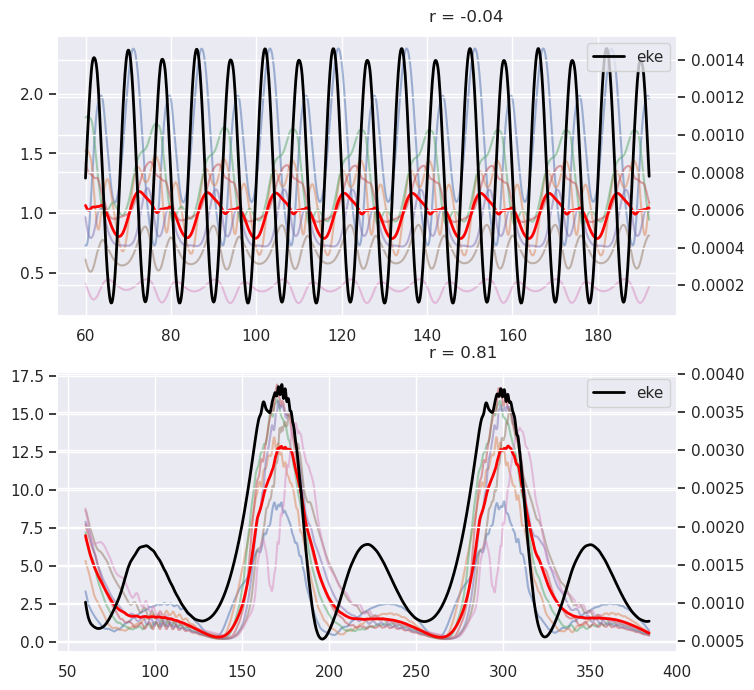

In [34]:
fig, axes = plt.subplots(nrows=len(configs), figsize=(8,8))
                         
for config, ax in zip(configs, axes):
    eke = calc_eke(config)
    t_days = eke.time / np.timedelta64(1, 'D')
    axt = ax.twinx()
    
    axt.plot(t_days, eke, color="black",label="eke", lw=2)
    
    
    vsum = np.zeros_like(eke)
    depths = [200,300, 400, 500,600, 700, 800]
    for depth in depths:
        vcont = calc_vorticity_contribution(config, depth=depth)
        vsum += vcont.values
        ax.plot(vcont.time, vcont, 
                 label=depth,
                 alpha = 0.5
                 #color="darkorange"
                 )
    
    vsum /= len(depths)
    ax.plot(t_days, vsum, lw=2, color="red")
    
    #ax.legend(loc="upper left", ncols=2)
    axt.legend(loc="upper right")
    
    r = np.corrcoef(eke, vsum)[0,1]
    ax.text(0.6, 1.05, f"r = {r:.2f}", transform=ax.transAxes)

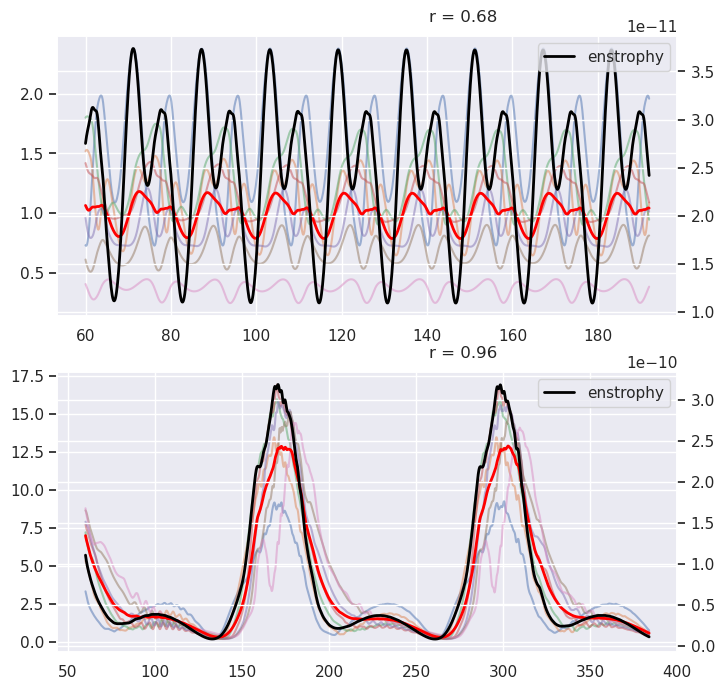

In [36]:
fig, axes = plt.subplots(nrows=len(configs), figsize=(8,8))
                         
for config, ax in zip(configs, axes):
    enstrophy = calc_enstrophy(config)
    t_days = enstrophy.time / np.timedelta64(1, 'D')
    axt = ax.twinx()
    
    axt.plot(t_days, enstrophy, color="black",label="enstrophy", lw=2)
    
    
    vsum = np.zeros_like(enstrophy)
    depths = [200,300, 400, 500, 600, 700, 800]
    #depths = [500]
    for depth in depths:
        vcont = calc_vorticity_contribution(config, depth=depth)
        vsum += vcont.values
        ax.plot(vcont.time, vcont, 
                 label=depth,
                 alpha = 0.5
                 #color="darkorange"
                 )
    
    vsum /= len(depths)
    ax.plot(t_days, vsum, lw=2, color="red")
    
    #ax.legend(loc="upper left", ncols=2)
    axt.legend(loc="upper right")
    
    r = np.corrcoef(enstrophy, vsum)[0,1]
    ax.text(0.6, 1.05, f"r = {r:.2f}", transform=ax.transAxes)

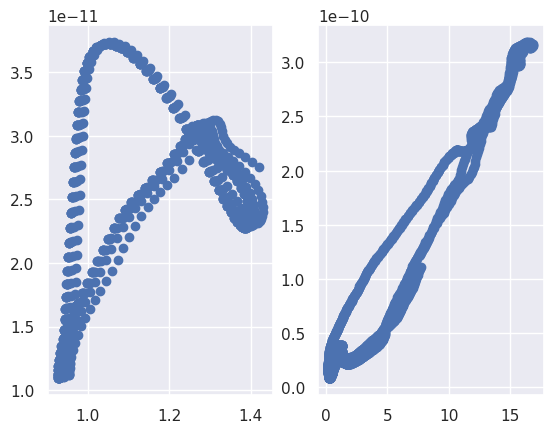

In [33]:
fig, axes = plt.subplots(ncols=len(configs))
                         
for config, ax in zip(configs, axes):
    enstrophy = calc_enstrophy(config)
    vcont = calc_vorticity_contribution(config)
    ax.scatter(vcont, enstrophy)